# Neural nets for BO


Source: https://gdmarmerola.github.io//ts-for-bayesian-optim/

In [4]:
import jax
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from rebayes_mini.methods import gauss_filter
from rebayes_mini.methods import base_filter

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sns.set_palette("colorblind")

In [7]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [293]:
jnp.set_printoptions(suppress=True, precision=4, linewidth=200)

In [8]:
def ackley_1d(x, y=0):
        out = (-20*jnp.exp(-0.2*jnp.sqrt(0.5*(x**2 + y**2))) 
           - jnp.exp(0.5*(jnp.cos(2*jnp.pi*x) + jnp.cos(2*jnp.pi*y)))
           + jnp.e + 20)
    
    # returning
    return out

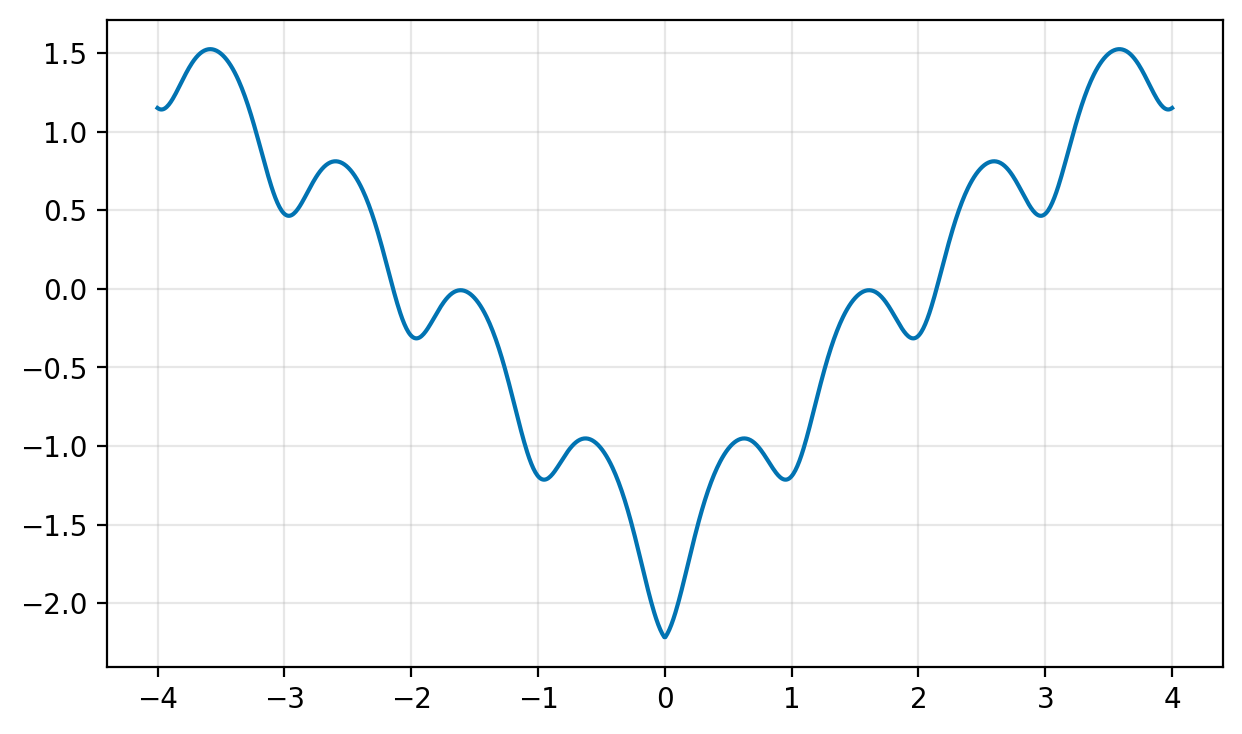

In [9]:
xrange = jnp.linspace(-4, 4, 1000)
yvals = ackley_1d(xrange)
ymean = yvals.mean()
ystd = yvals.std()
yvals = (yvals - ymean) / ystd

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)

## The BNN surrogate model

In [222]:
class MLP(nn.Module):
    n_hidden: int = 20

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last-layer")(x)
        return x

In [223]:
key = jax.random.PRNGKey(314)
key_data, key_train, key_sample = jax.random.split(key, 3)

## Training model

In [287]:
x_samples = jax.random.uniform(key_data, shape=(50,1), minval=-4, maxval=4)

In [288]:
y_samples = ackley_1d(x_samples)
y_samples = (y_samples - ymean) / ystd

In [289]:
import numpy as np

In [290]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 1e-8
agent = base_filter.SquareRootFilter(model.apply, cov_fn, dynamics_covariance=0.0, n_inner=10)
bel_init = agent.init_bel(params_init, cov=1.0)

bel, hist = agent.scan(bel_init, y_samples, x_samples)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 14.4 s, sys: 367 ms, total: 14.8 s
Wall time: 3.96 s


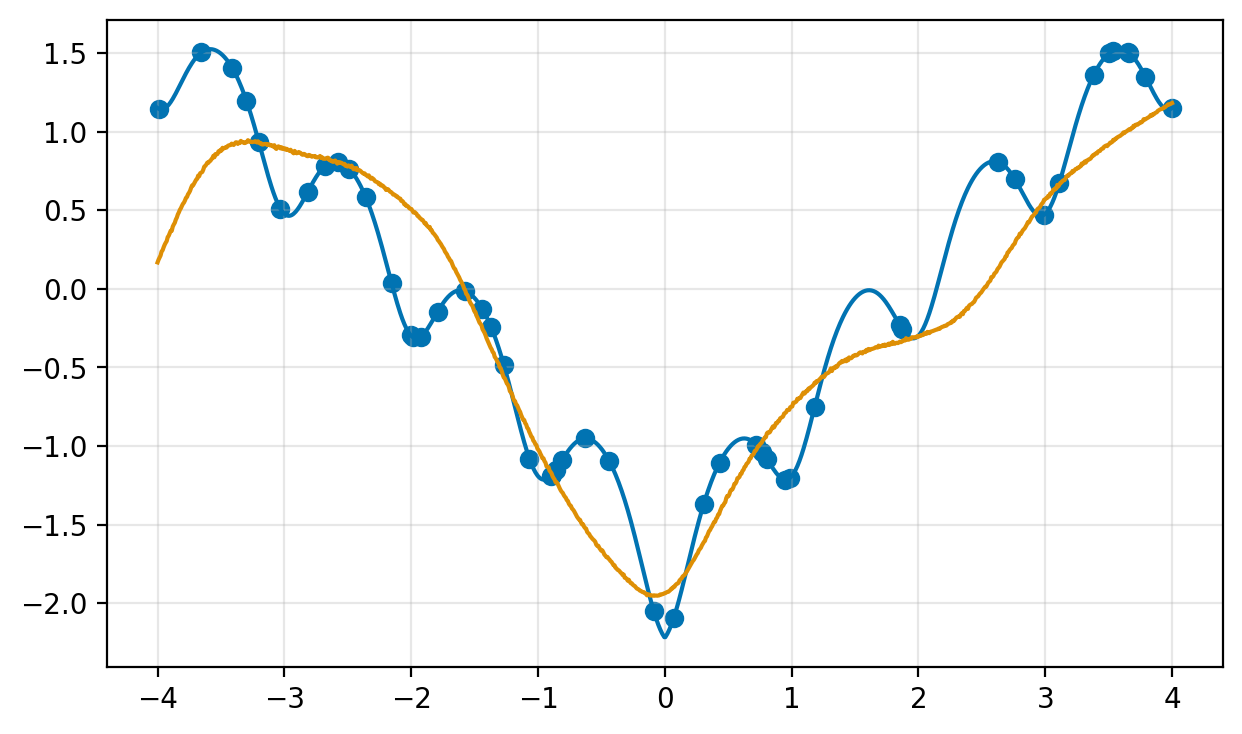

In [291]:
plt.scatter(x_samples, y_samples)

# for i, (x, y) in enumerate(zip(x_samples, y_samples)):
#     plt.text(x.item(), y.item(), i, fontsize=12, backgroundcolor="#ccc4")

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)
plt.plot(xrange, agent.mean_fn(bel.mean, xrange[:, None]))

## Copy

In [149]:
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (30,), 'kernel': (1, 30)},
  'Dense_1': {'bias': (30,), 'kernel': (30, 30)},
  'last-layer': {'bias': (1,), 'kernel': (30, 1)}}}

In [150]:
eps = jax.random.normal(key_sample, (100, len(bel.mean)))

In [151]:
sample_params = jnp.einsum("ji,sj->si", bel.W, eps) + bel.mean

In [152]:
eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

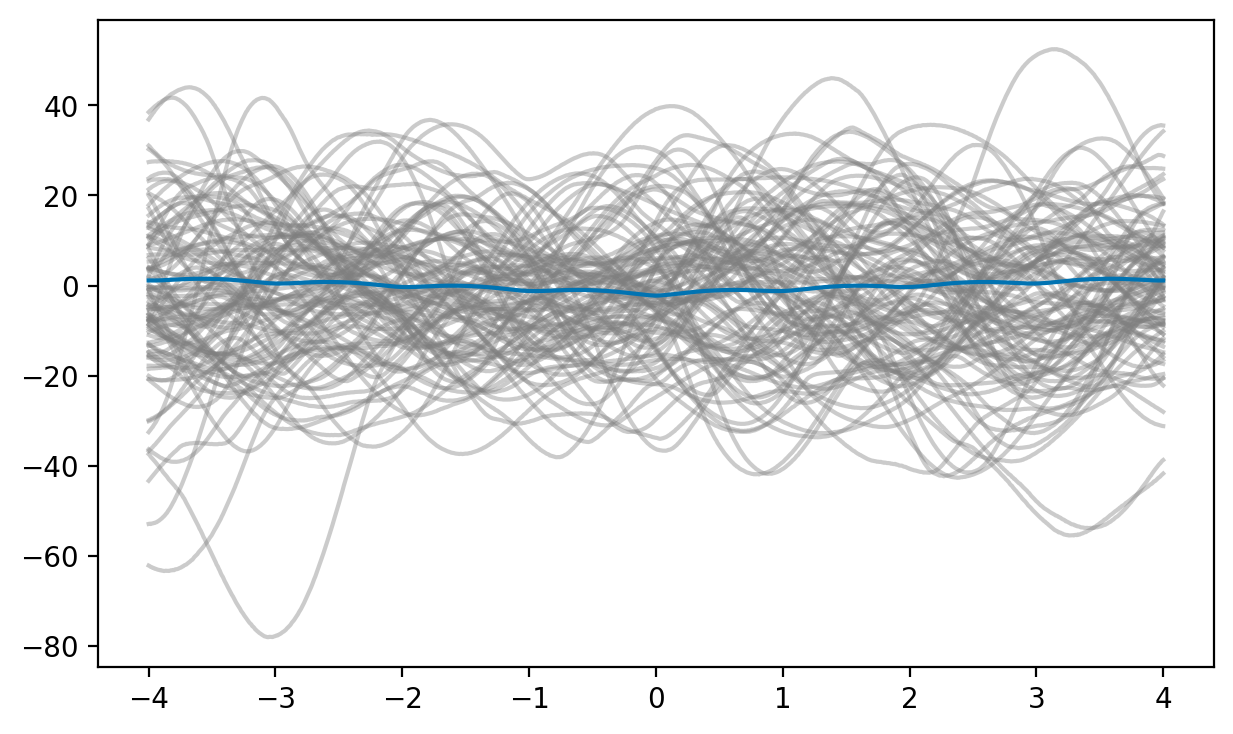

In [153]:
plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals)

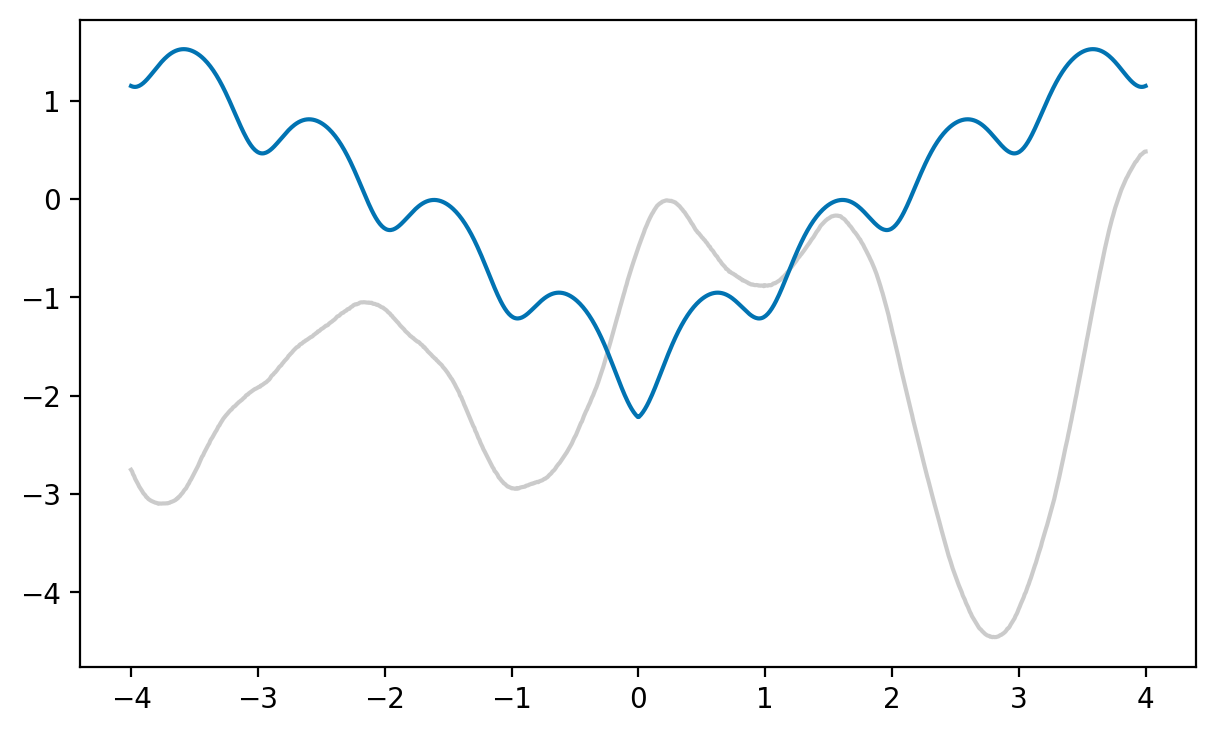

In [154]:
plt.plot(xrange, eval_samples.mean(axis=0), c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals)

## Sampling from last-layer only

In [155]:
from functools import partial

In [156]:
dim_ll = 21
W_ll = bel.W[-dim_ll:, -dim_ll:]
mean_ll = bel.mean[-dim_ll:]

In [157]:
eps = jax.random.normal(key_sample, (15, dim_ll))

In [158]:
mean_hidden = bel.mean[:-dim_ll]

In [170]:
sample_params = jnp.einsum("ji,sj->si", W_ll, eps) + mean_ll

In [171]:
@partial(jax.vmap, in_axes=(0, None, None))
def join_eval(ll_params, hidden_params, x):
    params = jnp.concat([hidden_params, ll_params])
    return agent.mean_fn(params, x).squeeze()

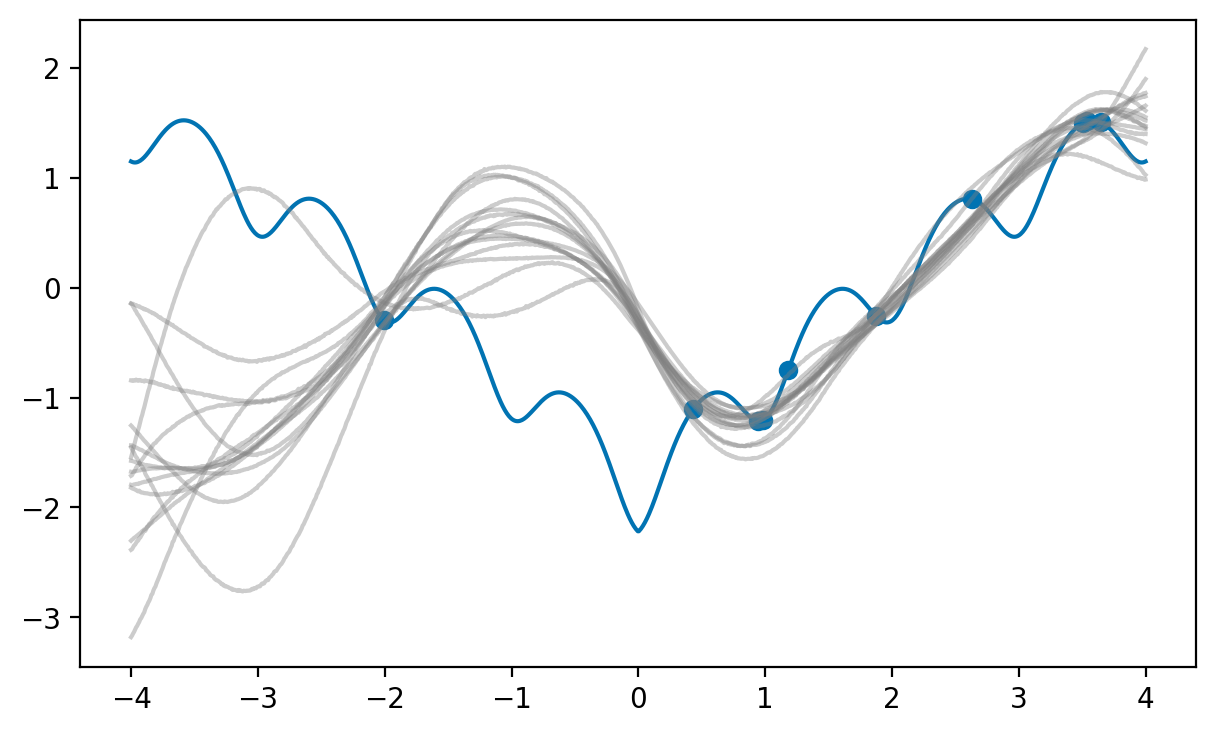

In [172]:
plt.plot(xrange, yvals)
ysamples = join_eval(sample_params, mean_hidden, xrange[:, None])
plt.plot(xrange, ysamples.T, c="gray", alpha=0.4)
plt.scatter(x_samples, y_samples);